<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Retrieving-Volcano-Locations" data-toc-modified-id="Retrieving-Volcano-Locations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Retrieving Volcano Locations</a></span></li><li><span><a href="#Retrieving-the-Data-for-the-Target" data-toc-modified-id="Retrieving-the-Data-for-the-Target-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Retrieving the Data for the Target</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plots</a></span></li></ul></div>

## Retrieving Volcano Locations
___

We have access to a datafile with 65 different volcano locations and approximate aperture sizes. We will use this to extract location specific data fromt the [MODVOLC](http://modis.higp.hawaii.edu/cgi-bin/modisnew.cgi) database.

In [1]:
import pandas as pd
from os import mkdir
from os.path import isdir

In [2]:
df_loc = pd.read_csv("data/volcanoes.txt", delimiter='\s', header=None, engine='python');

df_loc.columns = ["name", "long", "lat", "aperture"]

df_loc.nlargest(5, 'lat')

,name,long,lat,aperture
21,hekla,-19.70,63.98,0.3
5,augustine,-153.43,59.36,0.2
53,shiveluch,161.31,56.65,0.2
62,veniaminoff,-159.38,56.20,0.1
29,klyuckevskoi,160.65,56.06,0.3


In [3]:
target = df_loc[df_loc.name == 'veniaminoff'].values.flatten()

data_dir = f"data/{target[0]}/"

if not isdir(data_dir):
    mkdir(data_dir)

## Retrieving the Data for the Target
___

We have selected Kilauea as a temporary test target. Now, we will draw a box around the region and extract the data from MODVOLC.

In [4]:
from get_data import get_data

In [5]:
jyear = 2019
jday = 100
jperiod = 100000
lonmin = (target[1] - 2*target[3])
lonmax = (target[1] + 2*target[3])
latmin = (target[2] - 2*target[3])
latmax = (target[2] + 2*target[3])

df = get_data(jyear=jyear, jday=jday, jperiod=jperiod, lonmin=lonmin, lonmax=lonmax, latmin=latmin, latmax=latmax).sort_values('UNIX_Time').reset_index()
df.rename(index=str, columns={"Mo": "Month", "Dy": "Day", "Hr": "Hour", "Mn" : "Minute"}, inplace=True)

df["datetime"] = pd.to_datetime(df[["Year", "Month", "Day", "Hour", "Minute"]])
print(f"...{df.shape[0]} measurements retrieved...")

df.to_csv(f"{data_dir}data.csv")
df.head()

...859 measurements retrieved...


,index,UNIX_Time,Sat,Year,Month,Day,Hour,Minute,Longitude,Latitude,...,SunZen,SunAzi,Line,Samp,Ratio,Glint,Excess,Temp,Err,datetime
0,858,1106572199,A,2005,1,24,13,10,-159.385834,56.199917,...,134.36,50.28,1021,865,-0.65,123.461,28.647,256.5,12.3,2005-01-24 13:10:00
1,857,1107507000,T,2005,2,4,8,50,-159.398743,56.196945,...,133.96,-41.79,801,236,-0.79,142.426,14.081,257.6,6.2,2005-02-04 08:50:00
2,856,1107507000,T,2005,2,4,8,50,-159.392838,56.199482,...,133.96,-41.78,799,236,-0.71,141.696,19.949,257.6,6.2,2005-02-04 08:50:00
3,855,1107521399,A,2005,2,4,12,50,-159.381866,56.196911,...,133.67,41.91,1673,599,-0.70,136.611,22.275,256.9,6.2,2005-02-04 12:50:00
4,854,1107610499,A,2005,2,5,13,35,-159.379837,56.201195,...,128.92,54.74,748,1131,-0.76,101.250,18.500,256.9,6.2,2005-02-05 13:35:00


## Plots

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


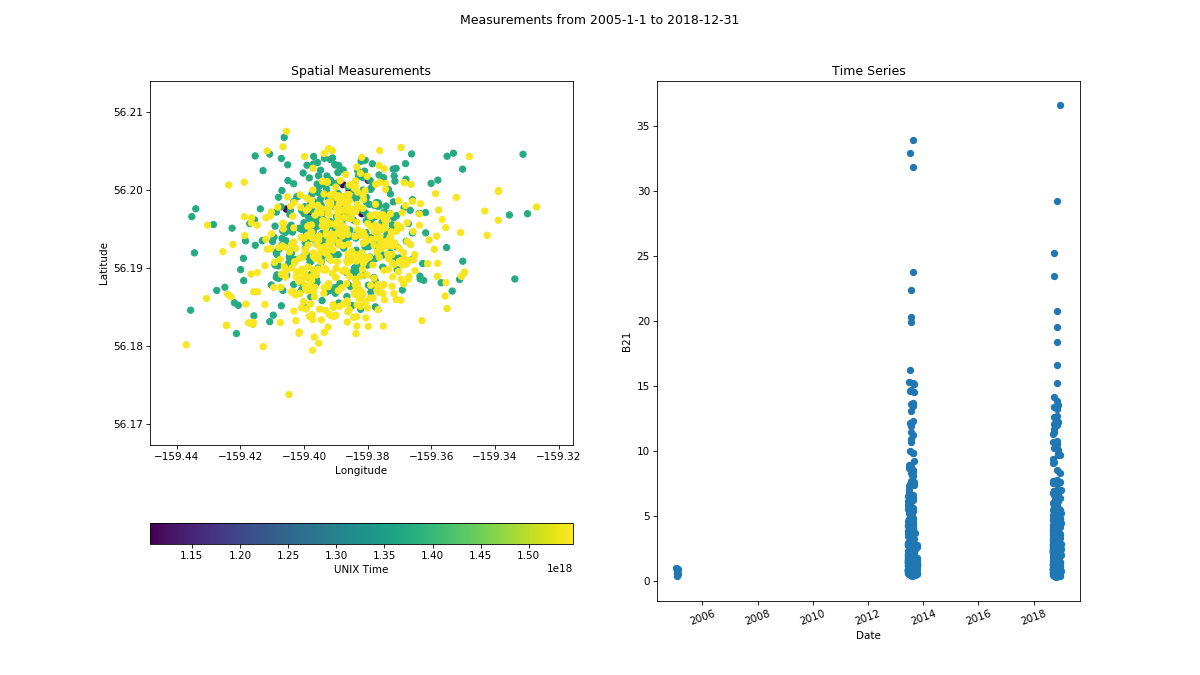

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16,9))

scatter = ax[0].scatter(df.Longitude, df.Latitude, c=df.datetime)#, cmap=plt.cm.autumn)
cbar = fig.colorbar(scatter, ax=ax[0], orientation='horizontal')
cbar.set_label('UNIX Time')

#ax[0].add_artist(plt.Circle(target[1:3], target[3]/2., color=]'k', fill=False))
ax[0].set_title("Spatial Measurements")
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")

scatter = ax[1].plot_date(df.datetime, df.B21)

ax[1].set_title("Time Series")
ax[1].set_xlabel("Date")
plt.xticks(rotation=20)
ax[1].set_ylabel("B21")

fig.suptitle(f"Measurements from {df.Year.min()}-{df.Month.min()}-{df.Day.min()} to {df.Year.max()}-{df.Month.max()}-{df.Day.max()}")
plt.savefig(f"{data_dir}/spatial_temporal.png", bbox_inches='tight', dpi=300)

<IPython.core.display.Javascript object>


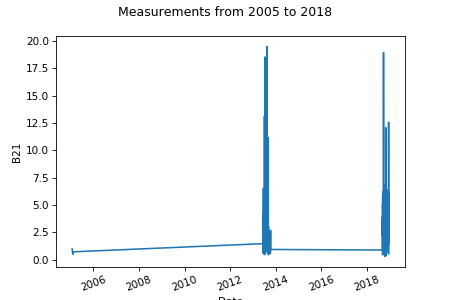

In [8]:
band = "B21"
temp = (df[band].groupby(df["UNIX_Time"]).unique().apply(pd.Series)).mean(axis=1)

fig = plt.figure(figsize=(6,4))
ax = plt.gca()

scatter = ax.plot(df.datetime.unique(), temp)#ax[1].plot_date(df.datetime.unique, temp)

ax.set_xlabel("Date")
plt.xticks(rotation=20)
ax.set_ylabel(f"{band}")

fig.suptitle(f"Measurements from {df.Year.min()} to {df.Year.max()}")
plt.savefig(f"{data_dir}/band_sum.png", bbox_inches='tight', dpi=300)

<IPython.core.display.Javascript object>


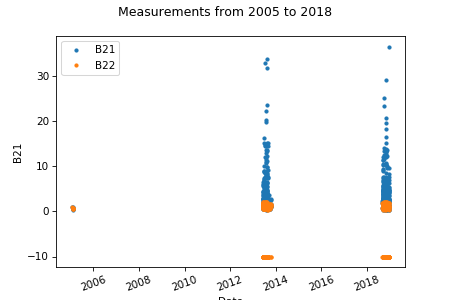

In [9]:
band = "B21"
temp = (df[band].groupby(df["UNIX_Time"]).unique().apply(pd.Series)).mean(axis=1)

fig = plt.figure(figsize=(6,4))
ax = plt.gca()

scatter = ax.plot(df.datetime, df.B21, '.', label='B21')#ax[1].plot_date(df.datetime.unique, temp)
scatter = ax.plot(df.datetime, df.B22, '.', label='B22')

ax.set_xlabel("Date")
plt.xticks(rotation=20)
ax.set_ylabel(f"{band}")

plt.legend()
fig.suptitle(f"Measurements from {df.Year.min()} to {df.Year.max()}")
plt.savefig(f"{data_dir}/b21_b22.png", bbox_inches='tight', dpi=300)